# Import required libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data

In [22]:
data_filename = 'tactics/data/stats/metrics_valid_maia1600_trial.csv'
df = pd.read_csv(data_filename)

# Do analysis

In [ ]:
df.describe()

## Group by tactic

In [16]:
df2 = df.groupby('tactic_text')
df2.describe()
agg = df2.aggregate(np.sum)
agg

,matches,divergence,avg,empty_suggestions,num_suggestions,correct_move,tactic_evals,ground_evals,best_move_evals,exec_time
tactic_text,,,,,,,,,,
"f(A,B,C):-legal_move(B,C,A)",1,0.0,0.0,0,1,1,366,366,366,0.080767
"f(A,B,C):-legal_move(B,C,A),attacks(B,C,A)",1,0.0,0.0,0,1,1,366,366,366,0.079788
"f(A,B,C):-legal_move(B,C,A),attacks(B,C,A),attacks(B,D,A),attacks(B,E,A),behind(B,D,E,A)",1,0.0,0.0,0,1,1,366,366,366,0.082509
"f(A,B,C):-legal_move(B,C,A),attacks(B,C,A),attacks(B,D,A),attacks(B,E,A),behind(B,E,D,A)",1,0.0,0.0,0,1,1,366,366,366,0.080564
"f(A,B,C):-legal_move(B,C,A),attacks(B,C,A),attacks(B,D,A),attacks(B,E,A),different_pos(D,E)",0,0.0,0.0,1,0,0,0,366,366,0.056628
...,...,...,...,...,...,...,...,...,...,...
"f(A,B,C):-legal_move(B,C,A),behind(B,E,D,A),different_pos(D,E)",0,0.0,0.0,1,0,0,0,366,366,0.056805
"f(A,B,C):-legal_move(B,C,A),behind(B,E,D,A),different_pos(D,E),different_pos(B,E)",0,0.0,0.0,1,0,0,0,366,366,0.061047
"f(A,B,C):-legal_move(B,C,A),behind(B,E,D,A),different_pos(D,E),different_pos(B,E),different_pos(C,D)",0,0.0,0.0,1,0,0,0,366,366,0.057390


In [ ]:
agg['avg_divergence'] = agg['divergence'] / agg['matches']
plt.hist(agg['avg_divergence'], bins=10)
plt.axvline(agg.loc[["f(A,B,C):-legal_move(B,C,A)"]]['avg_divergence'].values, linestyle='dashed')
plt.title('Histogram of Divergence $(T_{1600},$ Stockfish 14, $P_{test})$')
plt.xlabel('Divergence (Cp)')
plt.ylabel('Frequency')

In [ ]:
df.loc[(df['text'] == "f(A,B,C):-legal_move(B,C,A)")]['avg_divergence'].values

In [ ]:
plt.hist(df['avg'], bins=10)
plt.axvline(df.loc[(df['text'] == "f(A,B,C):-legal_move(B,C,A)")]['avg_divergence'].values, linestyle='dashed')

In [ ]:
agg['coverage'] = agg['matches'] / df.groupby(['position', 'move']).ngroups
plt.hist(agg['coverage'], bins=10)
plt.axvline(agg.loc[["f(A,B,C):-legal_move(B,C,A)"]]['coverage'].values, linestyle='dashed')
plt.title('Histogram of Coverage $(T_{1600}$, $P_{test})$')
plt.xlabel('Coverage')
plt.ylabel('Frequency')

In [ ]:
agg['accuracy'] = agg['correct_move'] / agg['matches']
plt.hist(agg['accuracy'], bins=10)
plt.axvline(agg.loc[["f(A,B,C):-legal_move(B,C,A)"]]['accuracy'].values, linestyle='dashed')
plt.title('Histogram of Accuracy $(T_{1600}$, $P_{test})$')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

In [ ]:
plt.hist(agg['tactic_evals'], bins=10)
plt.axvline(agg.loc[["f(A,B,C):-legal_move(B,C,A)"]]['tactic_evals'].values, linestyle='dashed', color='blue', label='Random tactic evaluation')
plt.axvline(agg.loc[["f(A,B,C):-legal_move(B,C,A)"]]['ground_evals'].values, linestyle='dashed', color='green', label='Ground move evaluation')
plt.axvline(agg.loc[["f(A,B,C):-legal_move(B,C,A)"]]['best_move_evals'].values, linestyle='dashed', color='red', label='Stockfish 14 best move evaluation')
plt.xlabel('Total Evaluation Score (Cp)')
plt.ylabel('Frequency')
plt.legend(loc=1)

In [ ]:
final = agg.sort_values(by = ['avg_divergence'], ascending = [True])
final

In [ ]:
list(final.index)

# Analyze Position Features

In [23]:
df['pos_move'] = df['position'] + "," + df['move']

In [24]:
df2 = df.groupby('pos_move')
agg = df2.aggregate(np.sum)
agg

,matches,divergence,avg,empty_suggestions,num_suggestions,correct_move,tactic_evals,ground_evals,best_move_evals,exec_time
pos_move,,,,,,,,,,
"3r4/1B3p1p/4pk2/2b2p2/Q1P5/P2P2PP/5n2/5R1K w - - 1 28,h1g2",325,33927.666667,33927.666667,144,329,2,-20303,19698,19698,35.411442
"4k3/p1p4p/1p4p1/8/8/P1Q5/5PPP/R2rK2R w KQ - 1 23,e1d1",332,13053.333333,13053.333333,137,346,9,-44656,-60970,-50652,35.921003
"8/3N4/7p/8/2K2Npk/P6P/5PP1/8 b - - 0 49,g4g3",16,448.166667,448.166667,453,23,10,637,29547,-4690,28.130674
"8/p7/1p6/1P2k3/PnP2R2/2K5/4N3/8 b - - 6 47,b4a2",2,226.666667,226.666667,467,6,0,-448,54404,54404,28.712242
"r1b1qb1r/3nk1p1/2P1p2p/p3Pp1Q/4p3/B6P/P1B2PPN/R4RK1 b - - 0 18,e7d8",2,0.000000,0.000000,467,4,2,50,11725,11725,27.353722
"r1b2rk1/pp3ppp/2n2n2/q1Pp2N1/8/P3P3/1QP2PPP/RN2KB1R w KQ - 1 13,b2c3",2,43.333333,43.333333,467,6,0,-76,12663,6566,30.567458
"r3k2B/p1p2p1p/p6n/3b4/8/5N2/P2N1PPP/R3R1K1 b q - 1 16,d5e6",2,84.000000,84.000000,467,6,0,244,-1876,67067,28.251340
"r4r2/1k1nq3/4p1p1/NP1bPp2/3P3p/3BQ3/1P3PPP/R1R3K1 b - - 0 27,a8a5",325,105.333333,105.333333,144,329,323,-69559,-100835,-21574,36.631233
"rn1k1Q2/pbpp2b1/1p6/8/3P4/2N3N1/PPP3PP/4RRK1 b - - 0 21,g7f8",325,0.000000,0.000000,144,325,325,118950,171654,171654,34.761903


Text(0, 0.5, 'Frequency')

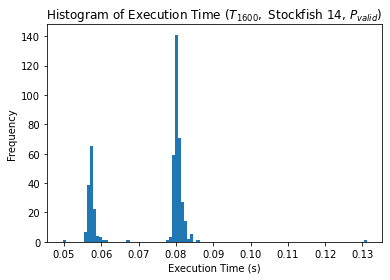

In [17]:
plt.hist(agg['exec_time'], bins=100)
plt.title('Histogram of Execution Time $(T_{1600},$ Stockfish 14, $P_{valid})$')
plt.xlabel('Execution Time (s)')
plt.ylabel('Frequency')

In [18]:
high_exec = agg[agg['exec_time'] > 100]
high_exec = high_exec.sort_values(by = ['exec_time'], ascending = [False])
high_exec

,matches,divergence,avg,empty_suggestions,num_suggestions,correct_move,tactic_evals,ground_evals,best_move_evals,exec_time
tactic_text,,,,,,,,,,


Text(0, 0.5, 'Frequency')

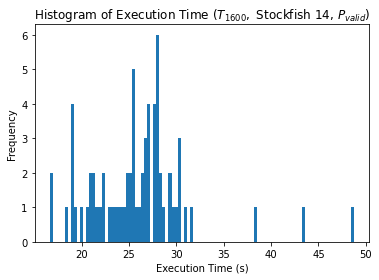

In [13]:
low_exec = agg[agg['exec_time'] <= 100]
plt.hist(low_exec['exec_time'], bins=100)
plt.title('Histogram of Execution Time $(T_{1600},$ Stockfish 14, $P_{valid})$')
plt.xlabel('Execution Time (s)')
plt.ylabel('Frequency')

In [26]:
num_exs = [1, 5, 20, 100]
time_vals = [27.5, 60 + 33, 60 * 6 + 33, 33 * 60 + 8]
num_tactics = [9, 117, 469, 837]

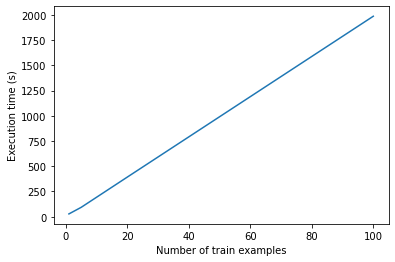

In [27]:
plt.plot(num_exs, time_vals)
plt.xlabel('Number of train examples')
plt.ylabel('Execution time (s)')
plt.show()

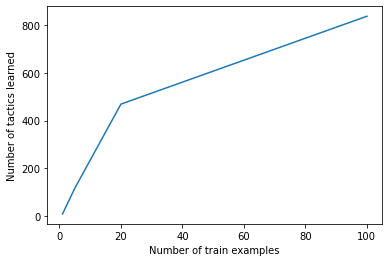

In [28]:
plt.plot(num_exs, num_tactics)
plt.xlabel('Number of train examples')
plt.ylabel('Number of tactics learned')
plt.show()

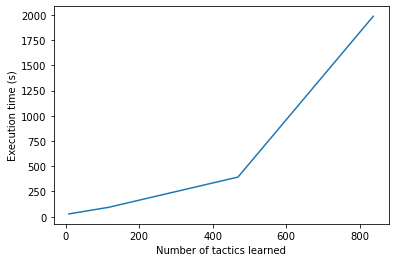

In [29]:
plt.plot(num_tactics, time_vals)
plt.xlabel('Number of tactics learned')
plt.ylabel('Execution time (s)')
plt.show()

# Calculate Dataset Metrics

In [ ]:
from collections import Counter

total_games = 0
valid_elo = 0
total_pos = 0
total_elo = 0
game_count = Counter()

pgn_path = 'tactics/data/lichess_db_standard_rated_2013-01.pgn'

In [ ]:
offsets = []
handle = open(pgn_path)
header = chess.pgn.read_headers(handle)

In [ ]:
header.get('Termination')


In [ ]:
import chess.pgn

with open(pgn_path) as pgn:
    while game := chess.pgn.read_game(pgn):
        total_games += 1
        white_elo = game.headers['WhiteElo']
        black_elo = game.headers['BlackElo']
        if '?' not in white_elo and '?' not in black_elo:
            total_elo += int(white_elo)
            total_elo += int(black_elo)
            valid_elo += 1
        game_count[game.headers['Event']] += 1

In [ ]:
print('Total games', total_games)
avg_elo = total_elo / (2 * valid_elo)
print('Average ELO', avg_elo)

In [ ]:
variance = 0

with open(pgn_path) as pgn:
    while game := chess.pgn.read_game(pgn):
        total_games += 1
        white_elo = game.headers['WhiteElo']
        black_elo = game.headers['BlackElo']
        if '?' not in white_elo and '?' not in black_elo:
            variance += (int(white_elo) - avg_elo) ** 2
            variance += (int(black_elo) - avg_elo) ** 2
        game_count[game.headers['Event']] += 1

In [ ]:
import math

print('SD', math.sqrt(variance / valid_elo))

# Test Evaluation

In [ ]:
import chess
import chess.engine
from tactics.util import *

board = chess.Board('r1bqk1nr/ppp2ppp/3b4/3p4/8/2PNP3/PP3PPP/RNBQKB1R b KQkq - 2 7')
move1 = chess.Move.from_uci('g8h6')
move2 = chess.Move.from_uci('g8f6')
engine_path = get_lc0_cmd(LC0, MAIA_1900) + ['--verbose-move-stats']
#engine_path = STOCKFISH
mate_score = 2000
n = 5

In [ ]:
with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
    analysis = engine.analyse(board, limit=chess.engine.Limit(depth=1), multipv=n, game=object())
    top_results = [(root['pv'][0], root['score'].relative.score(mate_score=mate_score)) for root in analysis]
    top_n_results = top_results[:n]

In [ ]:
top_n_results

In [ ]:
with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
    evals = get_evals(engine, board, [move1, move2])
evals